# Final Project

The virtual telephony service CallMeMaybe is developing some new functions that will give supervisors information on the clients with non-optimal plans.

#### Link to GoogleDrive with archive
Contains: presentation with my findings, link to the Tableau dashboard and documentation list.

https://drive.google.com/file/d/1_CYKghVhzt2bBaJkUZlft4jc0_ZVPwDS/view?usp=sharing

#### Link to the Tableau dashboard:
https://public.tableau.com/profile/sofia.toumin#!/vizhome/FinalProjectTelecomDashboard/CallMeMaybe

## Our Goals:

We need to find clients who:
1. Overpay for their current plan
2. Need bigger plans, since they'll be more advantageous

## Plan of work:

1. [Download the data and study the general information](#part1) <br>
2. Data preprocessing <br>
    2.1. [Duplicated rows](#part2_1) <br>
    2.2. [Missing values](#part2_2) <br>
    2.3. [Merging tables](#part2_3) <br>
3. [Exploratory data analysis](#part3) <br>
4. [Aggregating tables and calculating payment size](#part4) <br>
5. [Finding clients with non-optimal plans](#part5) <br>
6. [Various scenarios and their impact on profit](#part6) <br>
7. [Statistical tests](#part7) <br>
8. [General conclusions](#part8)

<a id="part1"></a>
### Download the data and study general information

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_style('darkgrid')

In [4]:
dataset = pd.read_csv(r'C:\Users\Sofia\datasets\telecom_dataset_us.csv', parse_dates=['date'])
clients = pd.read_csv(r'C:\Users\Sofia\datasets\telecom_clients_us.csv', parse_dates=['date_start'])

In [5]:
display(dataset.sample(10))
print(dataset.info())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
46469,168093,2019-10-22 00:00:00+03:00,out,False,941390.0,False,140,2772,4869
32756,167471,2019-11-22 00:00:00+03:00,in,False,NaN,True,3,0,106
40548,167827,2019-10-14 00:00:00+03:00,in,False,929424.0,False,64,922,1025
49118,168187,2019-11-20 00:00:00+03:00,out,False,937812.0,False,8,1031,1279
41801,167888,2019-11-16 00:00:00+03:00,in,False,NaN,True,36,0,777
14398,166836,2019-10-31 00:00:00+03:00,in,False,NaN,True,6,0,169
50536,168252,2019-11-15 00:00:00+03:00,out,False,NaN,False,16,8164,8366
46058,168091,2019-11-14 00:00:00+03:00,out,False,958470.0,True,1,0,31
21074,167016,2019-11-12 00:00:00+03:00,in,False,NaN,True,17,0,104
8120,166658,2019-08-29 00:00:00+03:00,out,False,891170.0,False,8,593,685


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                                
dtypes: bool

In [6]:
display(clients.sample(10))
print(clients.info())

,user_id,tariff_plan,date_start
253,168271,C,2019-10-18
181,168144,C,2019-10-15
190,168030,C,2019-10-09
15,168422,A,2019-10-24
90,167325,C,2019-09-11
93,167534,C,2019-09-19
173,168381,C,2019-10-23
118,168471,C,2019-10-28
345,166679,C,2019-08-14
603,167054,B,2019-08-29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB
None


We've downloaded data on clients and the main dataset, while doing this we parsed dates, this allowed us to save some space. There are no missing values in 'clients' table, there are missing values in main dataset: quite a lot of operators_id are missing, and some values in 'internal' column. Now let's start preprocessing!

### Data preprocessing:

<a id="part2_1"></a>
##### Duplicated rows:

In [7]:
#checking for duplicated rows in main dataset
print(dataset[dataset.duplicated()].empty)
print(dataset[dataset.duplicated()].shape[0])
print(len(dataset[dataset.duplicated()]) / len(dataset))

False
4900
0.09090571778412675


In [8]:
#checking duplicated rows to find the problem
for i in dataset[dataset.duplicated()].columns:
    print(i, ':', dataset[dataset.duplicated()][i].nunique())

user_id : 269
date : 115
direction : 2
internal : 2
operator_id : 776
is_missed_call : 2
calls_count : 178
call_duration : 1547
total_call_duration : 1820


In [9]:
#checking the duplicates dates distribution
print(dataset.date.describe())
print()
print(dataset[dataset.duplicated()].date.describe())

count                         53902
unique                          119
top       2019-11-25 00:00:00+03:00
freq                           1220
first     2019-08-02 00:00:00+03:00
last      2019-11-28 00:00:00+03:00
Name: date, dtype: object

count                          4900
unique                          115
top       2019-11-18 00:00:00+03:00
freq                            120
first     2019-08-03 00:00:00+03:00
last      2019-11-28 00:00:00+03:00
Name: date, dtype: object


In [10]:
#checking for duplicates in clients table
print(clients[clients.duplicated()].empty)

True


In [11]:
#dropping duplicated rows
dataset = dataset.drop_duplicates()

We found out 4900 duplicated rows in the main dataset, which is about 9% of the data. While exploring, we found out that this is a general issue: we have duplicated rows for 269 users, 776 operators, 115 out of 119 dates - seems like there's a technical problem with extracting the data to the database or something close. For now we'll remove these duplicates. <br>
Clients table is fine, there are no duplicated rows.

<a id="part2_2"></a>
##### Missing values

In [12]:
#checking missing values in "internal" column
print(len(dataset[dataset['internal'].isna()]))
print(len(dataset[dataset['internal'].isna()]) / len(dataset))

110
0.002244806334435329


In [13]:
#dropping rows with missing values in "internal" column
dataset.dropna(subset=['internal'], inplace=True)

In [14]:
#changing data type
dataset['internal'] = dataset['internal'].astype('bool')

In [15]:
#checking missing values in "operator_id" column
print(len(dataset[dataset['operator_id'].isna()]))
print(len(dataset[dataset['operator_id'].isna()]) / len(dataset))

7401
0.15137445798903706


While checking missing values, we found out that we have 110 rows where information whether the call was internal is missed. This is only 0.2% of our data, so we'll drop these rows (this information is important for our further study). Now we aslo can change this column's data type to boolean. <br>
We also found out that 7401 rows, or 15% of our data lack information about the operator. This information is not so critical for our study, so we'll leave it as it is.

Now let's merge the two tables we have into one, extract the call date and check that our data is correct.

<a id="part2_3"></a>
##### Merging tables into one dataset

In [16]:
#merging dataset with 'clients' table
dataset = pd.merge(dataset, clients, on='user_id', how='left')

In [17]:
#extracting call date and call month to use it later for grouping
dataset['date'] = pd.to_datetime(dataset['date'].apply(lambda x: x.date()))
dataset['call_month'] = dataset['date'].dt.strftime('%Y-%m')
dataset['call_month'] = dataset['call_month'].astype('datetime64[M]')
dataset['call_month'].value_counts()

2019-11-01    21507
2019-10-01    17146
2019-09-01     8381
2019-08-01     1858
Name: call_month, dtype: int64

In [18]:
#checking that we don't have calls made before the user was registered
dataset[dataset['date'] < dataset['date_start']].empty

True

In [19]:
#we'll consider active users as users whose last call was made in November (month the data was retrieved)
max_date = dataset.groupby('user_id')['date'].max().reset_index()
active_clients_list = max_date[max_date['date'] > '2019-10-31']['user_id'].to_list()
print(len(active_clients_list), dataset['user_id'].nunique())
print('{:.2f}'.format((len(active_clients_list)) / (dataset['user_id'].nunique())))

261 307
0.85


In [20]:
#adding new column with boolean values for active/non-active users
dataset['active'] = np.where(dataset['user_id'].isin(active_clients_list), True, False)

In [21]:
dataset.info()
dataset.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48892 entries, 0 to 48891
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
 9   tariff_plan          48892 non-null  object        
 10  date_start           48892 non-null  datetime64[ns]
 11  call_month           48892 non-null  datetime64[ns]
 12  active               48892 non-null  bool          
dtypes: bool(3), datetime64[ns](3), 

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start,call_month,active
10358,166691,2019-10-30,out,False,889410.0,False,10,293,472,C,2019-08-15,2019-10-01,True
41099,168062,2019-11-21,out,False,947616.0,False,48,1376,1921,A,2019-10-11,2019-11-01,True
618,166392,2019-11-18,in,False,891906.0,False,4,806,912,C,2019-08-01,2019-11-01,True
24606,167172,2019-10-30,out,False,904204.0,True,1,0,66,B,2019-09-05,2019-10-01,True
47565,168361,2019-11-09,out,False,945308.0,False,53,8769,9768,A,2019-10-23,2019-11-01,True


Now we have one big dataset with all the information we need for our study. We checked duplicates, missing values, changed columns' data types, extracted call month for grouping, added tariff plans. Now we're ready to start exploring.

<a id="part3"></a>
### Exploratory data analysis

In [22]:
#checking values distribution in 'clients' table
print(clients['user_id'].nunique())
print()
print(clients['tariff_plan'].value_counts())
print()
print(clients['date_start'].describe())

732

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

count                     732
unique                     73
top       2019-09-24 00:00:00
freq                       24
first     2019-08-01 00:00:00
last      2019-10-31 00:00:00
Name: date_start, dtype: object


In [23]:
#checking values distribution for our dataset
print(dataset['user_id'].nunique())
print()
print(dataset['date'].describe())
print()
print(dataset[['calls_count', 'call_duration', 'total_call_duration']].describe())
print()
print(dataset['direction'].value_counts())
print()
print(dataset['internal'].value_counts())
print()
print(dataset['is_missed_call'].value_counts())

307

count                   48892
unique                    119
top       2019-11-25 00:00:00
freq                     1107
first     2019-08-02 00:00:00
last      2019-11-28 00:00:00
Name: date, dtype: object

        calls_count  call_duration  total_call_duration
count  48892.000000   48892.000000         48892.000000
mean      16.495214     868.088788          1158.976458
std       63.671633    3779.549967          4456.180933
min        1.000000       0.000000             0.000000
25%        1.000000       0.000000            46.000000
50%        4.000000      37.000000           210.000000
75%       12.000000     573.000000           902.000000
max     4817.000000  144395.000000        166155.000000

out    28997
in     19895
Name: direction, dtype: int64

False    43239
True      5653
Name: internal, dtype: int64

False    27495
True     21397
Name: is_missed_call, dtype: int64


We have data on 307 unique users (signed up in period from August 1 to October 31, 2019; 261 of users (85%) were still active in November). We have data on their calls in period from August 2, 2019 to November 28, 2019. <br>
We know that the data is retrieved once a day, so calls are grouped by 'user_id', 'date', 'operator id', 'direction', and 'internal/external' columns, which gives us three aggregated columns: 'calls_count', 'call_duration' and 'total_call_duration'. They contain: number of calls made (including missed calls); total duration of calls (excluding waiting time); and total duration of calls (including waiting time), respectively. <br>
In 'calls_count' column we have values from 1 to 4817 calls (one call every 18 seconds, this must be someone very busy!).
As for 'call_duration' - we see values from 0 to 144395 seconds (again, very busy clients!), and in 'total_call_duration' we see values between 0 and 166155 seconds.

Now let's study calls duration to see if there's something standing out.

In [24]:
#checking whether we have rows where "call_duration" is greater than "total_call_duration"
dataset[dataset['call_duration'] > dataset['total_call_duration']].empty

True

In [25]:
#finding average call duration to see distribution
dataset['avg_call_duration'] = dataset['call_duration'] / dataset['calls_count']
dataset['avg_call_duration'].describe()

count    48892.000000
mean        66.562106
std        125.214395
min          0.000000
25%          0.000000
50%         23.775000
75%         90.000000
max       3550.000000
Name: avg_call_duration, dtype: float64

In [26]:
print(len(dataset[(dataset['call_duration'] == 0) & (dataset['is_missed_call'] == True)]))
print(len(dataset[(dataset['call_duration'] == 0) & (dataset['is_missed_call'] == False)]))

21102
17


First of all, there's no mistakes and values in 'call_duration' column are always smaller than values in 'total_call_duration' column. <br>
We divided 'call_duration' column by the number of calls to get the average call duration. Then we check the call duration distribution and we see that average call duration varies from 0 to 3550 seconds, mean duration is 66.5 seconds. We also see that more than 25% of calls have duration of 0. Let's check them separately to see whether these are missed calls. <br>
We see from proportion (21102 missed calls, 17 accepted), that everything's ok.

<a id="part4"></a>
### Aggregating tables and calculating payment size

In [27]:
#adding call month to data grouping so that we can calculate payment size for each client in each month
data = dataset.groupby(['user_id', 'call_month', 'internal', 'direction']).agg({'call_duration':'sum'}).reset_index()
#adding tariff plans 
data = data.merge(clients[['user_id', 'tariff_plan']], on='user_id', how='left')
#turning seconds to minutes, rounding result up
data['call_duration'] = np.ceil(data['call_duration'] / 60)
data.tail(10)

,user_id,call_month,internal,direction,call_duration,tariff_plan
1684,168583,2019-11-01,False,in,15.0,B
1685,168598,2019-11-01,False,in,70.0,C
1686,168601,2019-11-01,False,in,141.0,C
1687,168601,2019-11-01,False,out,405.0,C
1688,168601,2019-11-01,True,out,0.0,C
1689,168603,2019-11-01,False,in,0.0,B
1690,168603,2019-11-01,False,out,16.0,B
1691,168606,2019-11-01,False,in,12.0,C
1692,168606,2019-11-01,False,out,14.0,C
1693,168606,2019-11-01,True,out,61.0,C


In [28]:
#checking if there are clients who exeeded the free 2000 minute limit for internal calls
data[(data['internal'] == True) & (data['call_duration'] > 120000)].empty

True

We aggregated our data by 'user_id', 'call_month', 'internal' and 'direction' columns, which allows us to calculate the monthly usage of every user.

We've also found out that no clients exeeded the 2000 minutes (120000 seconds) limit of free internal calls, so in our case no one has to pay extra for internal calls; ingoing calls are free for all tariffs, so basically clients only have to pay for outgoing calls according to their tariff plan. <br>
For every clients we would also want to see how much they would've paid if they were to use different tariff plan. This will help us identify the overpaying clients.

##### Pricing

All prices are given in generic monetary units.

`Basic price of plan A` — 5000 <br>
`Basic price of plan B` — 2000 <br>
`Basic price of plan C` — 1000 <br>

`Incoming calls for all plans` — free <br>

`Internal calls for all plans` — a limit of 2000 free minutes per month, beyond which:

`Plan A` — 0.1 units/minute <br>
`Plan B` — 0.15 units/minute <br>
`Plan C` — 0.3 units/minute <br>

Outgoing (not internal) calls: <br>
`Plan A` — 0.4 units/minute <br>
`Plan B` — 0.5 units/minute <br>
`Plan C` — 0.7 units/minute 

In [29]:
#creating a function to calculate the payment for calls made
def calculate_payment(row):
    """This function iterates over rows and calculates payment size
    aacording to the type of call and client's tariff plan"""
    if row['internal'] == True:
        x = 0      #in our specific dataset no one exeeds the limit, so no one pays extra
    elif (row['internal'] == False) & (row['direction'] == 'in'):
        x = 0    #ingoing calls are free for all plans
    else:
        if row['tariff_plan'] == 'A':
            x = row['call_duration'] * 0.4
        elif row['tariff_plan'] == 'B':
            x = row['call_duration'] * 0.5
        else:
            x = row['call_duration'] * 0.7
    return x

In [30]:
data['client_paid'] = data.apply(lambda row : calculate_payment(row), axis=1) 
data.sample(5)

,user_id,call_month,internal,direction,call_duration,tariff_plan,client_paid
24,166399,2019-09-01,False,in,2.0,C,0.0
49,166407,2019-08-01,False,out,1.0,A,0.4
583,166946,2019-09-01,False,out,69.0,C,48.3
131,166511,2019-11-01,False,out,2486.0,C,1740.2
990,167285,2019-10-01,True,out,7.0,A,0.0


In [31]:
#creating a function to calculate the potential price of calls made for each user and each tariff
def calculate_potential_price(row, coef):
    """This function iterates over rows and calculates potential payment size
    depending on the price(coefficient) of specific tariff"""
    if row['internal'] == True:
        x = 0    
    elif (row['internal'] == False) & (row['direction'] == 'in'):
        x = 0
    else:
        x = row['call_duration'] * coef
    return x

In [32]:
#applying our function to calculate potential price for each user and each tariff
data['if_tariff_A'] = data.apply(lambda row : calculate_potential_price(row, 0.4), axis=1)
data['if_tariff_B'] = data.apply(lambda row : calculate_potential_price(row, 0.5), axis=1)
data['if_tariff_C'] = data.apply(lambda row : calculate_potential_price(row, 0.7), axis=1)
data.head(5)

,user_id,call_month,internal,direction,call_duration,tariff_plan,client_paid,if_tariff_A,if_tariff_B,if_tariff_C
0,166377,2019-08-01,False,in,22.0,B,0.0,0.0,0.0,0.0
1,166377,2019-08-01,False,out,1083.0,B,541.5,433.2,541.5,758.1
2,166377,2019-08-01,True,out,1.0,B,0.0,0.0,0.0,0.0
3,166377,2019-09-01,False,in,25.0,B,0.0,0.0,0.0,0.0
4,166377,2019-09-01,False,out,1427.0,B,713.5,570.8,713.5,998.9


Now we can group the data by user and month to add the basic price and calculate the final payment size for each client and each month.

In [33]:
#aggregating our table once again to calculate monthly payment
data = data.groupby(['user_id', 'call_month']).agg(
    {'client_paid':'sum', 'if_tariff_A':'sum', 'if_tariff_B':'sum', 'if_tariff_C':'sum'}).reset_index()
data = data.merge(clients, on='user_id', how='left')

In [34]:
data.head(5)

,user_id,call_month,client_paid,if_tariff_A,if_tariff_B,if_tariff_C,tariff_plan,date_start
0,166377,2019-08-01,541.5,433.2,541.5,758.1,B,2019-08-01
1,166377,2019-09-01,713.5,570.8,713.5,998.9,B,2019-08-01
2,166377,2019-10-01,680.0,544.0,680.0,952.0,B,2019-08-01
3,166377,2019-11-01,652.5,522.0,652.5,913.5,B,2019-08-01
4,166391,2019-08-01,0.0,0.0,0.0,0.0,C,2019-08-01


In [35]:
#calculating the delta between call month and sign-up date
data['difference'] = data['call_month'] - data['date_start']
data['difference'] = data['difference'].astype('timedelta64[D]')

In [36]:
#calculating coefficient, for positive delta it would be 1
data['coef'] = np.where(data['difference'] < 0, ((1 / 31) * (31 + (data['difference']))).round(2), 1)

In [37]:
#defining and applying function to calculate the final payment size (actual payment)
def final_payment_size(row):
    """This function iterates over rows and adds basic price to every client's payment"""
    if row['tariff_plan'] == 'A':
        x = row['client_paid'] + (5000 * row['coef'])
    elif row['tariff_plan'] == 'B':
        x = row['client_paid'] + (2000 * row['coef'])
    else:
        x = row['client_paid'] + (1000 * row['coef'])
    return x

data['client_paid'] = data.apply(lambda row : final_payment_size(row), axis=1)

In [38]:
#adding basic plan cost to our potential payment columns
data['if_tariff_A'] = data['if_tariff_A'] + (5000 * data['coef'])
data['if_tariff_B'] = data['if_tariff_B'] + (2000 * data['coef'])
data['if_tariff_C'] = data['if_tariff_C'] + (1000 * data['coef'])

In [39]:
#checking the result just to see that it works
data[data['coef'] < 1]

,user_id,call_month,client_paid,if_tariff_A,if_tariff_B,if_tariff_C,tariff_plan,date_start,difference,coef
15,166405,2019-08-01,2307.0,5143.6,2307.0,1483.8,B,2019-08-02,-1.0,0.97
19,166406,2019-08-01,3009.5,5705.6,3009.5,2467.3,B,2019-08-02,-1.0,0.97
23,166407,2019-08-01,4850.4,4850.4,1940.5,970.7,A,2019-08-02,-1.0,0.97
27,166428,2019-08-01,1940.0,4850.0,1940.0,970.0,B,2019-08-02,-1.0,0.97
31,166481,2019-08-01,4350.0,4350.0,1740.0,870.0,A,2019-08-05,-4.0,0.87
...,...,...,...,...,...,...,...,...,...,...
773,168473,2019-10-01,130.0,650.0,260.0,130.0,C,2019-10-28,-27.0,0.13
777,168500,2019-10-01,260.0,650.0,260.0,130.0,B,2019-10-28,-27.0,0.13
779,168522,2019-10-01,100.0,500.0,200.0,100.0,C,2019-10-29,-28.0,0.10
782,168575,2019-10-01,30.0,150.0,60.0,30.0,C,2019-10-31,-30.0,0.03


In [40]:
#extracting only outgoing external calls duration to add it to the table
outgoing_calls = dataset[(dataset['internal'] == False) & (dataset['direction'] == 'out')]
outgoing_calls_duration = outgoing_calls.groupby(['user_id', 'call_month']).agg({'call_duration':'sum'}).reset_index()
outgoing_calls_duration['call_duration'] = np.ceil(outgoing_calls_duration['call_duration'] / 60)

data = pd.merge(data, outgoing_calls_duration,  how='left', on=['user_id','call_month'])
data['call_duration'] = data['call_duration'].fillna(value=0)

In [41]:
data.head(10)

,user_id,call_month,client_paid,if_tariff_A,if_tariff_B,if_tariff_C,tariff_plan,date_start,difference,coef,call_duration
0,166377,2019-08-01,2541.5,5433.2,2541.5,1758.1,B,2019-08-01,0.0,1.0,1083.0
1,166377,2019-09-01,2713.5,5570.8,2713.5,1998.9,B,2019-08-01,31.0,1.0,1427.0
2,166377,2019-10-01,2680.0,5544.0,2680.0,1952.0,B,2019-08-01,61.0,1.0,1360.0
3,166377,2019-11-01,2652.5,5522.0,2652.5,1913.5,B,2019-08-01,92.0,1.0,1305.0
4,166391,2019-08-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,0.0,1.0,0.0
5,166391,2019-09-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,31.0,1.0,0.0
6,166391,2019-10-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,61.0,1.0,0.0
7,166391,2019-11-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,92.0,1.0,0.0
8,166392,2019-08-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,0.0,1.0,0.0
9,166392,2019-09-01,1000.0,5000.0,2000.0,1000.0,C,2019-08-01,31.0,1.0,0.0


We've got the aggregated table with monthly payment of each user and their external outgoing call duration. We added potential payment columns, so we can see how much each client would've paid if he was to use different tariff plan.<br>
Now we can check call duration distribution.

In [42]:
#calculating percentiles for call duration to define outliers
print(np.percentile(data['call_duration'], 90))
print(np.percentile(data['call_duration'], 95))
print(np.percentile(data['call_duration'], 98))
print(np.percentile(data['call_duration'], 99))

968.7999999999997
2150.699999999998
5524.199999999978
9595.800000000023


In [44]:
#call duration distribution for different tariff users
data.groupby(['tariff_plan'])['call_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff_plan,,,,,,,,
A,93.0,3281.408602,10959.384291,0.0,0.0,39.0,385.0,60724.0
B,289.0,397.020761,1162.223471,0.0,0.0,31.0,263.0,10251.0
C,410.0,280.082927,859.097475,0.0,0.0,1.0,114.0,7628.0


What about outgoing external call duration distribution? We know there are a lot users with call duration of 0, meaning they only get ingoing/internal calls; we also know that 90% of clients use less than 970 minutes of outgoing external calls a month, 95% of clients use less than 2150 minutes, and 99% of them use less than 9595 minutes. Since it's the only type of calls our clients are paying for, we can say that for 95% of clients tariff C would be optimal.

Now we can check payment size distribution and start looking for clients with non-optimal plans.

In [45]:
#checking payment size distribution
data['client_paid'].describe()

count      792.000000
mean      1910.582955
std       2221.194976
min         30.000000
25%       1000.000000
50%       1256.200000
75%       2049.875000
max      29289.600000
Name: client_paid, dtype: float64

In [46]:
#calculating percentiles to exclude outliers from the graph, so it'll be more informative
print(np.percentile(data['client_paid'], 90))
print(np.percentile(data['client_paid'], 95))
print(np.percentile(data['client_paid'], 99))

4332.839999999996
5043.38
7553.204000000021


We see that clients pay between 1000 and 29289 units a month, but 90% of them pay less than 5000, and 99% of them pay less than 8640. We'll plot payment size distribution graph for more than 99% clients by excluding outliers (clients who paid more than 10000).

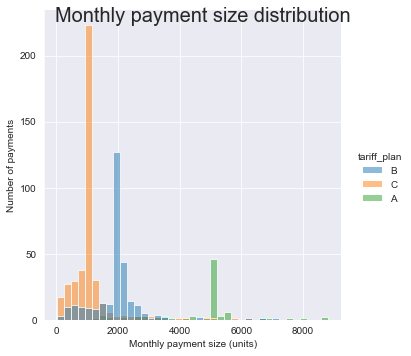

In [47]:
#visualizing payment size distribution among clients with different tariff plans
df = data[data['client_paid'] < 10000]

plot = sns.displot(data=df, x='client_paid', hue='tariff_plan')
plot.fig.suptitle("Monthly payment size distribution",
                  fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Monthly payment size (units)')
plt.ylabel('Number of payments')
plt.show()

<a id="part5"></a>
### Finding clients with non-optimal plans

According to the pricing we have, for each tariff we can define threshold after which client is overpaying:

For clients with tariff C formula would be (1000 + 0.7 * x) = (2000 + 0.5 * x), which gives us x of 5000.
That means that clients with tariff C who use more than 5000 minutes a month, overpay - they would pay less if they switched to tariff B. <br>
For clients with tariff B formula would be (2000 + 0.5 * x) = (5000 + 0.4 * x), which gives us x of 30000.
That means that clients with tariff B who use more than 30000 minutes a month, overpay - they would pay less if they switched to tariff A.

**General rule: tariff C is optimal for clients who use less than 5000 munites a month, tariff B is optimal for clients who use between 5000 and 30000 minutes a month, tariff A is optimal for clients who use more than 30000 minutes a month**

Now we want to calculate how much each client overpays and thus divide them into categories: clients who don't overpay, clients who overpay a little, and clients who overpay a lot. 

*Note that we don't want to switch tariff A users straight to tariff C without trying to switch them to tariff B first( this would allow us to loose less profit), so for overpaying tariff A clients we compare their payment to tariff B payment.*

In [48]:
#checking if there are clients with tariff C who should switch to A
data[(data['tariff_plan'] == 'C') & (data['call_duration'] > 30000)].empty

True

In [49]:
#creating a function to calculate how much each client overpays (if he overpays)
def calculate_overpayment_sum(row):
    """This function iterates over rows to find clients who could pay less than they actually paid;
    for such clients it calculates the amount of money they overpayed"""
    if row['tariff_plan'] == 'A':
        if row['client_paid'] > row['if_tariff_B']:
            x = row['client_paid'] - row['if_tariff_B']
        else:
            x = 0
    elif row['tariff_plan'] == 'B':
        if row['client_paid'] > row['if_tariff_C']:
            x = row['client_paid'] - row['if_tariff_C']
        elif row['client_paid'] > row['if_tariff_A']:
            x = row['client_paid'] - row['if_tariff_A']
        else:
            x = 0
    elif row['tariff_plan'] == 'C':
        if row['client_paid'] > row['if_tariff_B']:
            x = row['client_paid'] - row['if_tariff_B']
        elif row['client_paid'] > row['if_tariff_A']:
            x = row['client_paid'] - row['if_tariff_A']
        else:
            x = 0
    return x

In [50]:
#applying our function to create a column with exact amount of money overpayed
data['overpayed'] = data.apply(lambda row : calculate_overpayment_sum(row), axis=1)

In [51]:
#creating new column with amount of money overpayed compared to actual payment
data['overpayed, %'] = ((data['overpayed'] / data['client_paid']) * 100).round(2)

In [52]:
#adding active/non-active status to our data so we can explore clients who stopped using our service
data['active'] = np.where(data['user_id'].isin(active_clients_list), True, False)

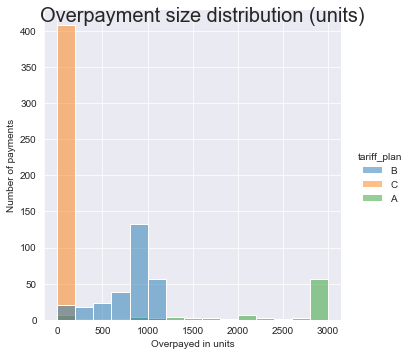

In [53]:
#visualizing overpayment in units

plot = sns.displot(data=data, x='overpayed', hue='tariff_plan')
plot.fig.suptitle("Overpayment size distribution (units)",
                  fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Overpayed in units')
plt.ylabel('Number of payments')
plt.show()

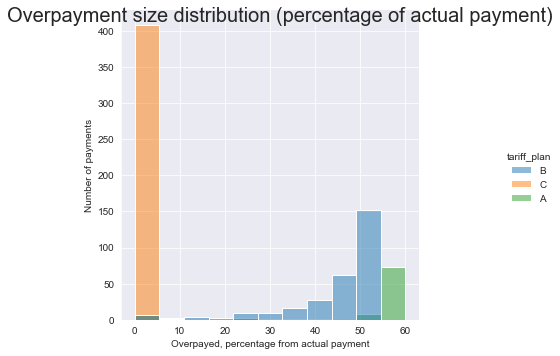

In [54]:
#visualizing overpayment in percentage of actual payment

plot = sns.displot(data=data, x='overpayed, %', hue='tariff_plan')
plot.fig.suptitle("Overpayment size distribution (percentage of actual payment)",
                  fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Overpayed, percentage from actual payment')
plt.ylabel('Number of payments')
plt.show()

From this graph we see that quite a lot of clients who don't overpay, we'll consider them as clients with optimal plans.
As for overpaying clients - they overpay from 1% to 60% of their payment. We'll consider clients who overpay up to 40% of their payment size as clients who overpay a little; and clients who overpay between 41% and 60% of their payment size as clients who overpay a lot.

In [55]:
#creating additional columns to divide clients into categories
data['optimal_plan'] = np.where(data['overpayed, %'] == 0, 1, 0)
data['overpay_slightly'] = np.where((data['overpayed, %'] > 0) & (data['overpayed, %'] <= 40), 1, 0)
data['overpay_a_lot'] = np.where(data['overpayed, %'] > 40, 1, 0)

In [56]:
#calculating share of overpaying users
print('Percentage of overpaying users in general:',
      (data[data['overpayed'] != 0]['user_id'].nunique() / data['user_id'].nunique()) * 100)

Percentage of overpaying users in general: 47.55700325732899


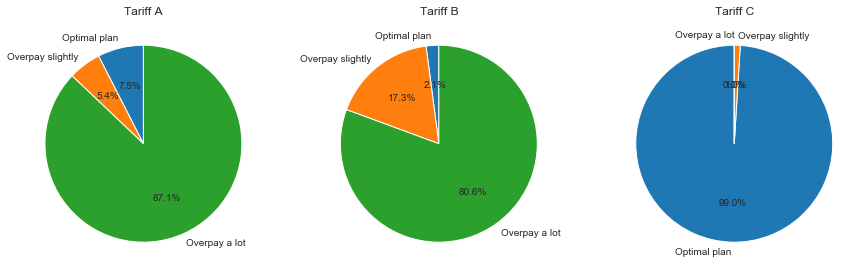

In [57]:
#visualizing overpayment status for each tariff plan
share = data.groupby('tariff_plan').agg({'optimal_plan':'sum', 'overpay_slightly':'sum', 'overpay_a_lot':'sum'}).reset_index()
labels = ['Optimal plan', 'Overpay slightly', 'Overpay a lot']

fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(15, 15)) 
#fig.suptitle('Share of overpaying users for each tariff', fontsize=20)

labels = labels
values = share.loc[0][1:4].values
ax1.pie(values,labels = labels,autopct = '%1.1f%%', startangle=90)
ax1.set_title('Tariff A')

labels = labels
values = share.loc[1][1:4].values
ax2.pie(values,labels = labels,autopct = '%1.1f%%', startangle=90)
ax2.set_title('Tariff B')

labels = labels
values = share.loc[2][1:4].values
ax3.pie(values,labels = labels,autopct = '%1.1f%%', startangle=90)
ax3.set_title('Tariff C')

fig.show()

Pie chart is informative here, but we'll make one more graph to combine all them.

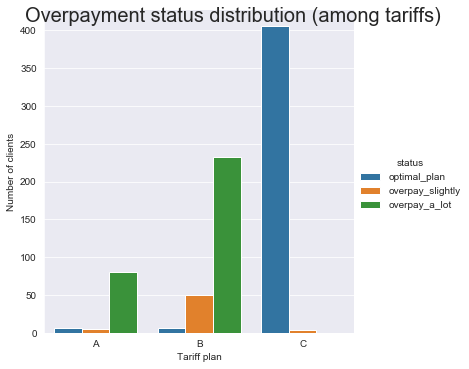

In [58]:
#checking how overpaying clients are distributed among tariff plans

df1 = data.groupby(['tariff_plan']).agg({'optimal_plan':'sum', 'overpay_slightly':'sum', 'overpay_a_lot':'sum'}).reset_index()
df1 = pd.melt(df1, id_vars="tariff_plan", var_name="status", value_name="size")

#visualizing overpayment in percentage of actual payment

plot = sns.catplot(x='tariff_plan', y='size', hue='status', data=df1, kind='bar')
plot.fig.suptitle("Overpayment status distribution (among tariffs)",
                  fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Tariff plan')
plt.ylabel('Number of clients')
plt.show()

Almost all tariff C users are marked as users with optimal plans, since it's the cheapest tariff. Small amount of them overpay slightly.<br>
Almost all tariff A users overpay a lot (remember that we compare payments of tariff A and B in this case). <br>
As for tariff B users: most of them overpay a lot, while some of them overpay slightly.

Oviously, this is a big problem - if all these overpaying clients will leave us for another company, what we'll be left with?
Let's study clients that already left (weren't active in November) to see if we could find any pattern.

In [59]:
#checking the difference between active and non-active users
active_status = data.groupby(['tariff_plan', 'active']).agg({'user_id':'nunique', 'client_paid':'mean', 'overpayed':'mean', 'overpayed, %':'mean'}).reset_index()
active_status

,tariff_plan,active,user_id,client_paid,overpayed,"overpayed, %"
0,A,False,4,6943.500000,2038.662500,42.248750
1,A,True,30,5483.181176,2386.065882,53.767647
2,B,False,16,1602.750000,680.400000,43.544167
3,B,True,96,1950.881132,802.947170,44.309283
4,C,False,26,1075.486792,16.067925,0.276226
5,C,True,135,1061.941176,1.045938,0.018431


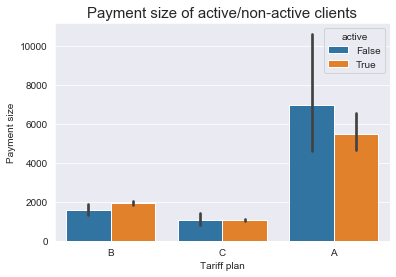

In [60]:
#visualizing payment size of active/non-active clients

plot = sns.barplot(x="tariff_plan", y="client_paid", hue="active", data=data)
plt.title("Payment size of active/non-active clients",
                  fontsize=15)
plt.xlabel('Tariff plan')
plt.ylabel('Payment size')

plt.show()

While checking the difference between active and non-active users (those who weren't active in November), we found out, that on average, clients who stopped using our service were paying more than those who stayed. It's really hard to compare such groups of clients in terms of how much they overpay, because as for tariff A users, for instance, - almost all of them overpay, so on graph we won't see clear difference.

Generally we can say few things based on our common sense: the higher the price and the more client overpays, the higher the probability that he'll leave us for another company. <br>
So basically company will lose profit anyway: either by lowing prices/switching tariffs, or by losing its clients. What can we do about it? <br>
We can either lose some profit by lowering the expences of overpaying clients (and therefore, increasing their loyalty to the company, meaning that LTV of these clients will also rise), or we can do nothing and lose even more profit if client will stop using our service at all.

To see the impact of potential changes we will calculate company's profit for each tariff for various scenarios. At this point we'll keep only active users in our dataset.

<a id="part6"></a>
### Various scenarios and their impact

In [61]:
#leaving only active users in our dataset
data = data[data['active'] == True]

In [62]:
#adding column with potential profit based on condition:
#if client doesn't overpay - nothing changes, 
#if he overpays - substracts the overpay from actual payment
data['if_all_overpaying_switch'] = np.where(data['overpayed, %'] > 0, data['client_paid'] - data['overpayed'], data['client_paid'])
data['if_all_overpaying_leave'] = np.where(data['overpayed, %'] > 0, 0, data['client_paid'])

In [63]:
#aggregating table
profit = data.groupby(['call_month', 'tariff_plan']).agg({'client_paid':'sum', 'if_all_overpaying_leave':'sum', 'if_all_overpaying_switch':'sum'}).reset_index()
profit

,call_month,tariff_plan,client_paid,if_all_overpaying_leave,if_all_overpaying_switch
0,2019-08-01,A,34006.4,12793.2,21332.2
1,2019-08-01,B,37644.5,3603.0,23505.1
2,2019-08-01,C,15750.6,15750.6,15750.6
3,2019-09-01,A,95413.2,29289.6,55886.6
4,2019-09-01,B,102866.0,7125.5,60180.2
5,2019-09-01,C,64579.8,64579.8,64579.8
6,2019-10-01,A,151139.2,34980.8,84043.8
7,2019-10-01,B,163122.0,11263.0,95345.6
8,2019-10-01,C,135661.5,129989.6,135288.1
9,2019-11-01,A,185511.6,26589.2,101992.2


What can we say? It's not easy to lose profit, but it's a little easier if you know you could lose more.
We see pretty clearly that switching overpaying clients to optimal tariff would lead to significant decrease in profit, but on the other hand, losing all those clients would be a disaster - we would lose almost all users from tariff plans A and B!

It's easy to choose between these two possibilities, but what will happen if we'll offer to switch tariffs only to users who overpay a lot? 

In [64]:
#adding columns with new values based on condition
data['if_overpaying_a_lot_switch'] = np.where(data['overpayed, %'] > 40, data['client_paid'] - data['overpayed'], data['client_paid'])
data['if_overpaying_a_lot_leave'] = np.where(data['overpayed, %'] > 40, 0, data['client_paid'])

In [65]:
#aggregating and merging into one table
profit1 = data.groupby(['call_month', 'tariff_plan']).agg({'if_overpaying_a_lot_switch':'sum', 'if_overpaying_a_lot_leave':'sum'}).reset_index()
profit = profit.merge(profit1, on=['call_month', 'tariff_plan'])
profit

,call_month,tariff_plan,client_paid,if_all_overpaying_leave,if_all_overpaying_switch,if_overpaying_a_lot_switch,if_overpaying_a_lot_leave
0,2019-08-01,A,34006.4,12793.2,21332.2,21332.2,12793.2
1,2019-08-01,B,37644.5,3603.0,23505.1,27210.5,16299.5
2,2019-08-01,C,15750.6,15750.6,15750.6,15750.6,15750.6
3,2019-09-01,A,95413.2,29289.6,55886.6,55886.6,29289.6
4,2019-09-01,B,102866.0,7125.5,60180.2,65914.6,26314.5
5,2019-09-01,C,64579.8,64579.8,64579.8,64579.8,64579.8
6,2019-10-01,A,151139.2,34980.8,84043.8,85334.8,38656.8
7,2019-10-01,B,163122.0,11263.0,95345.6,105841.0,43659.5
8,2019-10-01,C,135661.5,129989.6,135288.1,135661.5,135661.5
9,2019-11-01,A,185511.6,26589.2,101992.2,108509.2,51521.2


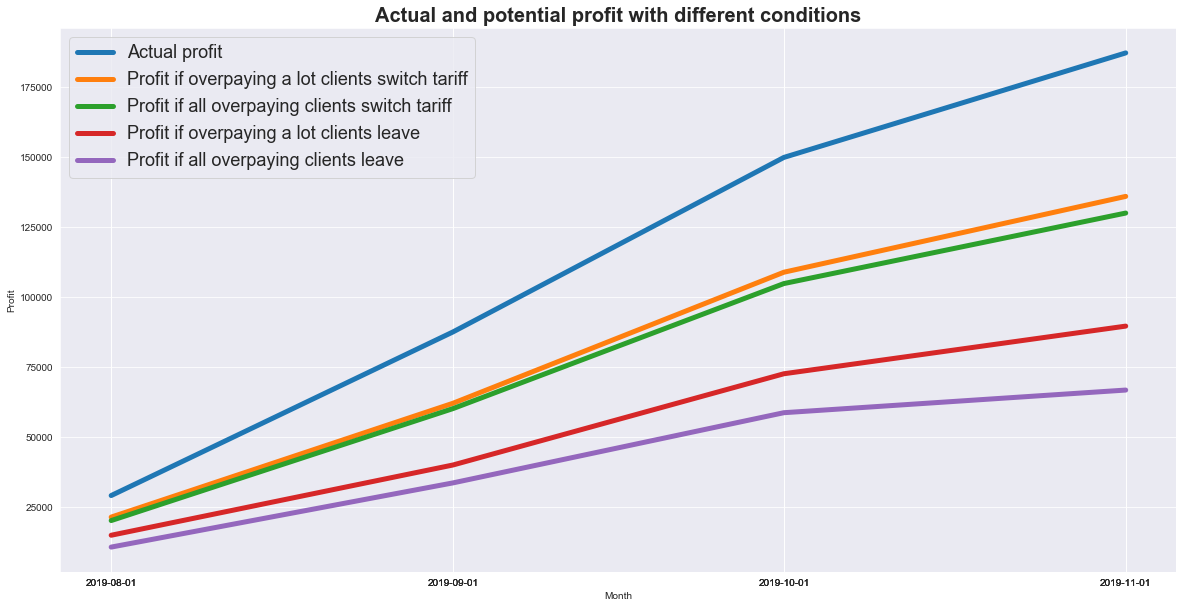

In [66]:
#visualizing actual and potential profit for different conditions

plt.figure(figsize=(20,10))
sns.lineplot(data=profit, x='call_month', y='client_paid', label='Actual profit', ci=None, linewidth=5)
sns.lineplot(data=profit, x='call_month', y='if_overpaying_a_lot_switch', label='Profit if overpaying a lot clients switch tariff', ci=None, linewidth=5)
sns.lineplot(data=profit, x='call_month', y='if_all_overpaying_switch', label='Profit if all overpaying clients switch tariff', ci=None, linewidth=5)
sns.lineplot(data=profit, x='call_month', y='if_overpaying_a_lot_leave', label='Profit if overpaying a lot clients leave', ci=None, linewidth=5)
sns.lineplot(data=profit, x='call_month', y='if_all_overpaying_leave', label='Profit if all overpaying clients leave', ci=None, linewidth=5)


plt.title('Actual and potential profit with different conditions', fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Month')
plt.ylabel('Profit')
plt.xticks(profit['call_month'])
plt.legend(fontsize=18)
plt.show()

On this graph we see the company's profit with different scenarios: actual profit, profit if all overpaying clients switch, profit if all overpaying clients leave, profit if overpaying a lot customers switch, profit if overpaying a lot customers leave. <br>
Obviously, we wouldn't want any clients to leave: that would drop company's profit deep down. As for switching - switching all overpaying customers is pretty close to switching overpaying a lot customers, so it's the question of risk the company's ready to take.

Now let's do the same with average monthly payment.

In [67]:
#aggregating table
avg_payment = data.groupby(['call_month', 'tariff_plan']).agg({'client_paid':'mean', 'if_all_overpaying_leave':'mean', 
                                                               'if_all_overpaying_switch':'mean', 'if_overpaying_a_lot_switch':'mean', 
                                                               'if_overpaying_a_lot_leave':'mean'}).reset_index().round(2)
avg_payment

,call_month,tariff_plan,client_paid,if_all_overpaying_leave,if_all_overpaying_switch,if_overpaying_a_lot_switch,if_overpaying_a_lot_leave
0,2019-08-01,A,3400.64,1279.32,2133.22,2133.22,1279.32
1,2019-08-01,B,1254.82,120.10,783.50,907.02,543.32
2,2019-08-01,C,583.36,583.36,583.36,583.36,583.36
3,2019-09-01,A,5963.32,1830.60,3492.91,3492.91,1830.60
4,2019-09-01,B,1836.89,127.24,1074.65,1177.05,469.90
5,2019-09-01,C,949.70,949.70,949.70,949.70,949.70
6,2019-10-01,A,5211.70,1206.23,2898.06,2942.58,1332.99
7,2019-10-01,B,1965.33,135.70,1148.74,1275.19,526.02
8,2019-10-01,C,1068.20,1023.54,1065.26,1068.20,1068.20
9,2019-11-01,A,6183.72,886.31,3399.74,3616.97,1717.37


In [68]:
avg_payment.groupby('call_month').agg({'client_paid':'mean', 'if_all_overpaying_leave':'mean', 
                                       'if_all_overpaying_switch':'mean', 'if_overpaying_a_lot_switch':'mean', 
                                       'if_overpaying_a_lot_leave':'mean'}).reset_index().round(2)

,call_month,client_paid,if_all_overpaying_leave,if_all_overpaying_switch,if_overpaying_a_lot_switch,if_overpaying_a_lot_leave
0,2019-08-01,1746.27,660.93,1166.69,1207.87,802.00
1,2019-09-01,2916.64,969.18,1839.09,1873.22,1083.40
2,2019-10-01,2748.41,788.49,1704.02,1761.99,975.74
3,2019-11-01,3204.81,735.70,1970.64,2082.45,1164.21


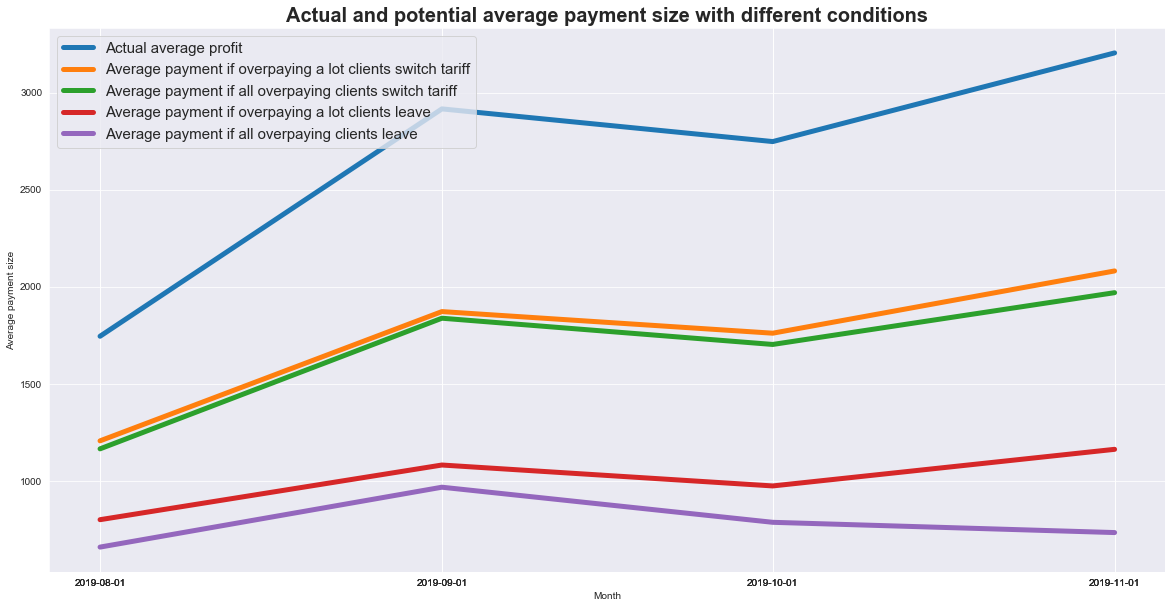

In [69]:
#visualizing actual and potential average profit for different conditions

plt.figure(figsize=(20,10))
sns.lineplot(data=avg_payment, x='call_month', y='client_paid', label='Actual average profit', ci=None, linewidth=5)
sns.lineplot(data=avg_payment, x='call_month', y='if_overpaying_a_lot_switch', label='Average payment if overpaying a lot clients switch tariff', ci=None, linewidth=5)
sns.lineplot(data=avg_payment, x='call_month', y='if_all_overpaying_switch', label='Average payment if all overpaying clients switch tariff', ci=None, linewidth=5)
sns.lineplot(data=avg_payment, x='call_month', y='if_overpaying_a_lot_leave', label='Average payment if overpaying a lot clients leave', ci=None, linewidth=5)
sns.lineplot(data=avg_payment, x='call_month', y='if_all_overpaying_leave', label='Average payment if all overpaying clients leave', ci=None, linewidth=5)


plt.title('Actual and potential average payment size with different conditions', fontsize=20, fontdict={"weight": "bold"})
plt.xlabel('Month')
plt.ylabel('Average payment size')
plt.xticks(profit['call_month'])
plt.legend(fontsize=15)
plt.show()

The picture is pretty much the same: losing overpaying clients (all of them or part of them) would significantly drop average monthly payment. Switching tariff for all overpaying users would give us pretty similar result as switching tariff only for users who overpay a lot.<br>
Let's look at November, for example. Actual average payment size is 3205 units; if all overpaying clients would leave, average payment size drops to 735 units; but if they switch it would be 1970 units. Another option: if overpaying a lot clients would leave, average payment size would be 1164 units, but if they switch, it would be 2082. Is the difference in average payment size of 2082 and 1970 units worth taking risk of losing customers who overpay slightly? That might be company's next step.

<a id="part7"></a>
### Statistical tests

We would like to prove that switching overpaying users to optimal tariff really has an impact on average payment size.<br>
Before we start, we would like to check if our samples come from population with normal distribution. We'll use Shapiro-Wilk test here. Our null hypothesis is that the data is normally distributed, our alternative hypothesis is that the data isn't normally distributed.

In [70]:
print(st.shapiro(data['client_paid']))
print(st.shapiro(data['if_overpaying_a_lot_switch']))
print(st.shapiro(data['if_all_overpaying_switch']))
print(st.shapiro(data['if_overpaying_a_lot_leave']))
print(st.shapiro(data['if_all_overpaying_leave']))

(0.4859994649887085, 6.674384585579104e-41)
(0.3021377921104431, 2.802596928649634e-45)
(0.27348965406417847, 0.0)
(0.34598416090011597, 2.1019476964872256e-44)
(0.2657715082168579, 0.0)


We get p-value significantly less than 0.05, meaning that for every sample our null hypothesis is rejected. <br>
Now we can say that none of our samples is normally distributed. <br>
That means that we're going to use Mann Whitney statistical test.

In [71]:
def mann_whitney_u_test(distribution):
    """Perform the Mann-Whitney U Test, comparing actual payment distribution with other distributions.
    """
    alpha = .05
    u_statistic, p_value = st.mannwhitneyu(data['client_paid'], distribution)
    
    print(distribution.name)
    print(u_statistic, p_value)
    if (p_value < alpha):
        print('Reject the null hypothesis')
    else:
        print('Failed to reject null hypothesis')

In [72]:
#running statistical tests for our samples
mann_whitney_u_test(data['if_overpaying_a_lot_switch'])
print()
mann_whitney_u_test(data['if_all_overpaying_switch'])
print()
mann_whitney_u_test(data['if_overpaying_a_lot_leave'])
print()
mann_whitney_u_test(data['if_all_overpaying_leave'])

if_overpaying_a_lot_switch
188914.5 7.668566554588092e-16
Reject the null hypothesis

if_all_overpaying_switch
182097.5 3.8180028787927805e-19
Reject the null hypothesis

if_overpaying_a_lot_leave
113778.5 1.6320963235743667e-71
Reject the null hypothesis

if_all_overpaying_leave
85783.5 1.7589976016532855e-103
Reject the null hypothesis


For all of our samples the null hypothesis is rejected. That means that all our samples differ significantly from original payment distribution, therefore, we can say that any change in company's policy would lead to significant changes.

<a id="part8"></a>
### General conclusions

After studying clients with different tariffs and their payments, we discovered that actually 98% of our clients use less than 5000 minutes a month, which means that tariff plan C is optimal for them. Tariff B is optimal for very small amount of clients and tariff A is almost exclusively optimal for 1 or 2 clients who really use more than 30000 minutes of external outgoing calls a month. <br>
If we look at the actual situation, we see that it's different and almost all users of tariffs B and A are overpaying, and most of them are overpaying a lot (between 40 to 60% of their actual payment). <br>
The company doesn't want to lose its clients, so it's critical we'll do something to keep them. <br>
The first option is to switch all users to their optimal tariff. This would lead to descrease in profit, but increase in loyalty, so lifetime value of such clients will grow. <br>
Other option is to switch only those users who overpay a lot: this make the loss smaller. On the other hand, we wouldn't want to lose any clients, so company should think about possibe risk.

In general, switching only overpaying a lot users wouldn't save us significant amount of profit, and it won't increase loyalty in clients who overpay slightly. <br>
Taking all that into account, I would recommend switching all users to their optimal plans - in long perspective this would allow us to keep all loyal users and therefore keep the profit.